In [73]:
import numpy as np
import matplotlib.pyplot as plt
from MyML import *

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def ReLU(x):
    return(x*(x>0))

def deReLU(x):
    return(x>0)

#Derivative of TanH function
def derivTanh(z):
    return (1-z**2)

#tanh function
def tanh(z):
    t = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    return t

#normalize function
def normalize(x, maxX, minX):
    for i in range(x.shape[1]):
        x[:,i] = (x[:,i]-minX[i])/(maxX[i]-minX[i])
    return x

#Cost function
def costfunction(p, y):
    j = -np.sum(y*np.log(p))
    n = j/(p.shape[0])
    return n

def leakyReLU(x):
    z = x*(x>0)+.2*x*(x<=0)
    return z

def deleakyReLU(x):
    z = (x>0)+(x<=0)*.2
    return z

#Sigmoid function
def sigmoid(h):
    p = 1/(1+np.exp(-h))
    return p

#Softmax function
def softmax(h):
    p = np.exp(h)
    p = p/(p.sum(1).reshape(h.shape[0],1))
    return p

class tsnn:
    
    def __init__(self, indims, listOfNodes, activation = tanh, derivActivations = derivTanh, taskClassify = True):
        
        self.indims = indims
        self.listOfNodes = listOfNodes
        self.activation = activation
        self.derivActivations = derivActivations
        self.taskClassify = taskClassify
        self.layers = len(listOfNodes)
    
    def CrossEntropy(self, y, p):
        if self.taskClassify == True:
            if self.listOfNodes[-1] == 1:
                j = -np.sum(y *np.log(p)+(1-y)*np.log(1-p))
            else:
                j = -(np.sum(y*np.log(p)))
        else:
            if self.listOfNodes[-1] == 1:
                j = (p-y).T@(p-y)
            else:
                j = (sum((y-p)**2))
        t = y.shape[0]
        return(j/t)
    
    def getscalesX(x):
        maxVal = []
        minVal = []
        for col in range(tx.shape[1]):
            maxVal.append(max(x[:,col]))
            minVal.append(min(x[:,col]))
        self.xmaxes = maxVal
        self.xmins = minVal
        
    def getscalesY(x):
        maxVal = []
        minVal = []
        for col in range(tx.shape[1]):
            maxVal.append(max(x[:,col]))
            minVal.append(min(x[:,col]))
        self.ymaxes = maxVal
        self.ymins = minVal
        
    def normX(x):
        return(normalize(x, self.xmaxes, self.xmins))
    
    def normy(y):
        return(normalize(y, self.ymaxes, self.ymins))
        
    def weightInitialization(self):
        self.weights = {}
        self.biases = {}
        self.weights['W1'] = np.random.randn(self.indims, self.listOfNodes[0])
        self.biases['B1'] = np.random.randn(1, self.listOfNodes[0])
        for i in range(2, self.layers + 1):
            self.weights['W'+str(i)] = np.random.randn(self.listOfNodes[i-2],self.listOfNodes[i-1])
            self.biases['B'+str(i)] = np.random.randn(1, self.listOfNodes[i-1])
            
    def predict(self, X):
        if self.taskClassify:
            if self.listOfNodes[-1] == 1:
                self.finAct = sigmoid
            else:
                self.finAct = softmax
        self.Z['1'] = self.activation(X@self.weights['W1'] + self.biases['B1'])
        for i in range(2, self.layers):
            self.Z[str(i)] = self.activation(self.Z[str(i-1)]@self.weights['W'+str(i)] + self.biases['B'+str(i)])
        if self.taskClassify:
            self.prediction = self.finAct(self.Z[str(self.layers - 1)]@self.weights['W' + str(self.layers)] + self.biases['B'+str(self.layers)])
        else:
            self.prediction = self.Z[str(self.layers - 1)]@self.weights['W' + str(self.layers)] + self.biases['B'+str(self.layers)]
            
    def train(self, X, y, lr = .0001, epochs = 500, weightScaling = False, momentum = False, NAG = False, showPlot = True, mu = 0, showAccuracy = False):
        self.D = {}
        self.Z = {}
        self.weightInitialization()
        if momentum or NAG:
            self.momentum = {}
            self.bomentum = {}
            if NAG:
                self.motemp = {}
                self.botemp = {}
                self.gradw = {}
                self.gradb = {}
            for i in range(self.layers):
                self.momentum[str(i+1)] = np.zeros((self.weights['W'+str(i+1)].shape))
                self.bomentum[str(i+1)] = np.zeros((self.biases['B'+str(i+1)].shape))
        if weightScaling:
            for i in range(self.layers, 1, -1):
                self.weights['W' + str(i)] = (self.weights['W' + str(i)])*(np.sqrt(2/(self.listOfNodes[i-1]+self.listOfNodes[i-2])))
                self.biases['B' + str(i)] = (self.biases['B' + str(i)])*(np.sqrt(2/(self.listOfNodes[i-1]+self.listOfNodes[i-2])))
            self.weights['W' + str(1)] = (self.weights['W' + str(1)])*(np.sqrt(2/(self.listOfNodes[0]+self.listOfNodes[1])))
            self.biases['B' + str(1)] = (self.biases['B' + str(1)])*(np.sqrt(2/(self.listOfNodes[0]+self.listOfNodes[1])))
        errors = []
        for epoch in range(epochs):
            
            #Pre-Weight Update
            self.predict(X)
            p = self.prediction
            self.Z['0'] = X
            self.Z['1'] = self.activation(X@self.weights['W1'] + self.biases['B1'])
            self.D[str(self.layers)] = (p-y)
            for i in range(2, self.layers):
                    self.Z[str(i)] = self.activation(self.Z[str(i-1)]@self.weights['W'+str(i)] + self.biases['B'+str(i)])
            #NO MOMENTUM
            if not (momentum or NAG):
                self.weights['W' + str(self.layers)] = (self.weights['W' + str(self.layers)] - lr * (self.Z[str(self.layers - 1)].T @ self.D[str(self.layers)]))  
                self.biases['B' + str(self.layers)] = self.biases['B' + str(self.layers)] - lr * (np.sum(self.D[str(self.layers)], axis = 0))
                for i in range(self.layers - 1, 0, -1):
                    self.D[str(i)] = (self.D[str(i+1)]@self.weights['W'+str(i+1)].T)*self.derivActivations(self.Z[str(i)])
                    self.weights['W' + str(i)] = (self.weights['W' + str(i)] - lr*(self.Z[str(i-1)].T@self.D[str(i)]))
                    self.biases['B' + str(i)] = self.biases['B' + str(i)] - lr * (np.sum(self.D[str(i)], axis = 0))
                    
            #MOMENTUM
            elif momentum:
            
                self.momentum[str(self.layers)] = mu * self.momentum[str(self.layers)] - lr * (self.Z[str(self.layers - 1)].T @ self.D[str(self.layers)])
                self.weights['W' + str(self.layers)] = (self.weights['W' + str(self.layers)] + self.momentum[str(self.layers)])
                self.bomentum[str(self.layers)] = mu * self.bomentum[str(self.layers)] - lr * (np.sum(self.D[str(self.layers)], axis = 0))
                self.biases['B' + str(self.layers)] = self.biases['B' + str(self.layers)] + self.bomentum[str(self.layers)]
                
                for i in range(self.layers - 1, 0, -1):
                    self.D[str(i)] = (self.D[str(i+1)]@self.weights['W'+str(i+1)].T)*self.derivActivations(self.Z[str(i)])
                    self.momentum[str(i)] = mu * self.momentum[str(i)] - lr*(self.Z[str(i-1)].T@self.D[str(i)])
                    self.weights['W' + str(i)] =  self.weights['W' + str(i)] + self.momentum[str(i)]
                    self.bomentum[str(i)] = mu * self.bomentum[str(i)] -  lr * (np.sum(self.D[str(i)], axis = 0))
                    self.biases['B' + str(i)] = self.biases['B' + str(i)] + self.bomentum[str(i)]
                    
            #Training with NESTOR ACCELERATED GRADIENT
            elif NAG:
                for i in range(1, self.layers+1):
                    self.motemp[str(i)] = self.momentum[str(i)]
                    self.botemp[str(i)] = self.bomentum[str(i)]
                for i in range(1, self.layers+1):
                    self.weights['W' + str(i)] = (self.weights['W' + str(i)] + mu * self.momentum[str(i)])
                    self.biases['B' + str(i)] = self.biases['B' + str(i)] + mu * self.bomentum[str(i)]
                self.predict(X)
                p = self.prediction
                self.Z['0'] = X
                self.Z['1'] = self.activation(X@self.weights['W1'] + self.biases['B1'])
                self.D[str(self.layers)] = (p-y)
                for i in range(2, self.layers):
                    self.Z[str(i)] = self.activation(self.Z[str(i-1)])@self.weights['W'+str(i)] + self.biases['B'+str(i)]
                for i in range(self.layers - 1, 0, -1):
                    self.D[str(i)] = (self.D[str(i+1)]@self.weights['W'+str(i+1)].T)*self.derivActivations(self.Z[str(i)])
                for i in range(self.layers, 0, -1):
                    self.gradw[str(i)] = lr*(self.Z[str(i-1)].T@self.D[str(i)])
                    self.gradb[str(i)] = lr * (np.sum(self.D[str(i)], axis = 0))
                for i in range(1, self.layers + 1):
                    self.weights['W' + str(i)] = self.weights['W' + str(i)] - mu * self.motemp[str(i)]
                    self.biases['B' + str(i)] = self.biases['B' + str(i)] - mu * self.botemp[str(i)]
                for i in range(1, self.layers + 1):
                    self.momentum[str(i)] = mu * self.momentum[str(i)] - self.gradw[str(i)]
                    self.bomentum[str(i)] = mu * self.bomentum[str(i)] - self.gradb[str(i)]
                for i in range(1, self.layers + 1):
                    self.weights['W' + str(i)] = self.weights['W' + str(i)] + self.momentum[str(i)]
                    self.biases['B' + str(i)] = self.biases['B' + str(i)] + self.bomentum[str(i)]
                
            self.predict(X)
            p = self.prediction
            errors.append(self.CrossEntropy(y,p))
            if showAccuracy and self.taskClassify:
                if self.listOfNodes[-1] == 1:
                    output = np.rint(p)
                    
                else:
                    indices = np.argmax(p, axis = 1)
                    output = np.zeros((y.shape))
                    for i in range(len(indices)):
                        output[i,indices[i]] = 1
                if np.mean(output == y) == 1:
                    print(np.mean(output == y)*100, "% accuracy at iteration", epoch)
                    showAccuracy = False
                
                
        if showPlot:
            plt.plot(errors)
            plt.show()
        return errors

In [75]:
#normalize function
def normalize(x):
    for i in range(x.shape[1]):
        x[:,i] = (x[:,i]-min(x[:,i]))/(max(x[:,i]) - min(x[:,i]))
    return x

#One Hot Encoder
def OneHotEncode(x, columns):
    
    #New matrix to store result
    newMatrix = np.array([[]])
    
    #Iterate through every column
    for column in range(x.shape[1]):
        
        #Check to see if column is in list of specified columns. If so, one hot encode it.
        if column in columns:
            distinctValues = np.unique(x[:,column])
            encoded = np.zeros((x.shape[0],len(distinctValues)))
            print(encoded.shape)
            for item in range(x.shape[0]):
                for i in range(len(distinctValues)):
                    if x[item,column] == distinctValues[i]:
                        encoded[item,i] = 1
                        
        #If not in list of columns, store unedited column in "encoded".
        else:
            encoded = x[:,column].reshape((x.shape[0],1))
            
        #Sets newmatrix to result on first iteration
        if newMatrix.size == 0:
            newMatrix = encoded
            
        #Adds each column to the result. Works whether specified or not.
        else:
            newMatrix = np.hstack((newMatrix, encoded))
    return newMatrix  

(900, 3)


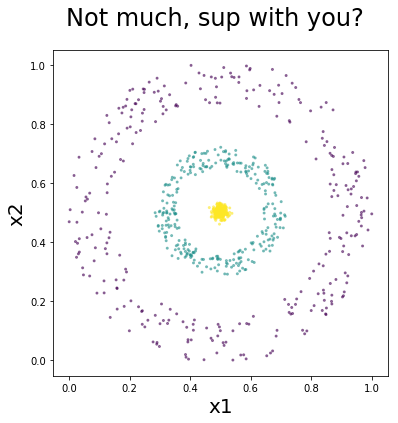

array([[0.50486152, 0.47469636],
       [0.50183274, 0.50884085],
       [0.46303016, 0.51747155],
       ...,
       [0.51729317, 0.52010866],
       [0.89315026, 0.41635926],
       [0.50743195, 0.50940328]])

In [76]:
samples = 300
x1 = np.random.randn(1,2)*50
while 5 >= np.sqrt((x1[0,0]**2) + (x1[0,1]**2)) or 7 <= np.sqrt((x1[0,0]**2) + (x1[0,1]**2)):
    x1 = np.random.randn(1,2)*50
while x1.shape[0]<samples:
    x = np.random.randn(1,2)*50
    while 5 >= np.sqrt((x[0,0]**2) + (x[0,1]**2)) or 7 <= np.sqrt((x[0,0]**2) + (x[0,1]**2)):
        x = np.random.randn(1,2)*50
    x1 = np.vstack((x1,x))
x2 = np.random.randn(1,2)*2
while 2 >= np.sqrt((x2[0,0]**2) + (x2[0,1]**2)) or 3 <= np.sqrt((x2[0,0]**2) + (x2[0,1]**2)):
    x2 = np.random.randn(1,2)*2
while x2.shape[0]<samples:
    x = np.random.randn(1,2)*2
    while 2 >= (np.sqrt((x[0,0]**2) + (x[0,1]**2))) or 3 <= (np.sqrt((x[0,0]**2) + (x[0,1]**2))):
        x = np.random.randn(1,2)*2
    x2 = np.vstack((x2,x))
x3 = np.random.randn(samples,2)*(1/6)
x = np.vstack((x1,x2, x3))
x = normalize(x)
Y = np.vstack((np.zeros((samples,1)), np.ones((samples,1)), (np.ones((samples,1))+1)))
y = OneHotEncode(Y, [0])
rows = np.arange(x.shape[0]).reshape(x.shape[0],1)
np.random.shuffle(rows)
x = np.matrix(x[rows[:,0], :])
y = np.matrix(y[rows[:,0], :])
x = np.array(x)
y = np.array(y)
Y = np.matrix(Y[rows[:,0], :])
Y = np.array(Y)
plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], s = 4, alpha = .5, c = Y[:,0])
plt.suptitle("Not much, sup with you?", fontsize = 24)
plt.xlabel("x1", fontsize = 20)
plt.ylabel("x2", fontsize = 20)
plt.show()
x

Weights not previously initialized. Initializing now.
11250


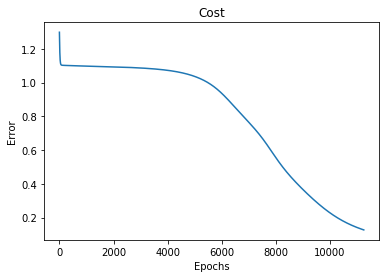

In [69]:
tanmodel = TSNN(indims = 2, nodes = [20,20,20,3], taskType = 'c')
tanmodel.train(x,y)
relumodel = tsnn(x.shape[1], [20,20,20,3], activation = ReLU, derivActivations = deReLU)

100.0 % accuracy at iteration 2461


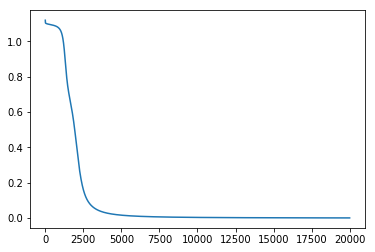

100.0 % accuracy
0.0013365605068870062


In [109]:
lr = .00004
epochs = 20000
tanmodel = tsnn(2,[20,20,20,3], activation = np.tanh, derivActivations = derivTanh)
j = tanmodel.train(x,y, showAccuracy = True, lr = lr, epochs = epochs, weightScaling = True, NAG = False, mu = .8)
p = tanmodel.prediction
tandices = np.argmax(p, axis = 1)
tanpred = np.zeros((y.shape))
for i in range(len(tandices)):
    tanpred[i,tandices[i]]= 1
print(np.mean(tanpred == y)*100, "% accuracy")
print(min(j))

In [24]:
tanmodel.weightInitialization()
tanmodel.weights

{'W1': array([[ 1.07904459,  0.50387641,  0.14991443, -0.16424434, -0.98315711,
          0.40565691,  0.35768588, -0.62453036, -1.37196198,  2.29101132,
         -0.91374954, -0.08793923, -0.02945224, -0.6458229 ,  0.6119597 ,
          1.2792901 ,  1.90219168,  0.18417832, -0.35316192,  1.08441996],
        [ 1.73671334,  0.38917268,  0.40966131,  1.01172685, -0.38157909,
          0.14945661,  0.41090192,  0.64946591,  0.02328324, -1.31699   ,
         -1.45615504,  0.53922424,  0.42193693, -1.78940144, -1.0264368 ,
         -2.21284964,  0.59885252,  1.05821234,  2.14906589,  0.49506202]]),
 'W2': array([[-1.77295511e+00, -6.72701725e-01,  1.74258717e+00,
         -1.54754214e+00,  5.61767051e-01, -5.46554397e-01,
          9.11204057e-01, -2.14549189e+00, -1.06443799e+00,
          4.07123796e-01, -1.89057557e-01, -6.73175187e-01,
          7.66887654e-01,  4.74301891e-01,  1.45918764e+00,
          4.63846804e-01, -2.82092016e-01, -5.34765001e-01,
          1.73672816e-01, -6.765

I tried TanH with varied learning rates and epochs, and always ran into a problem when it started to get close. I checked my code over and over again, and corroborated that it should work by checking with others in the group. My weight updates and theirs are nearly identical, and only tanh throws this error at me. So it's only after trying everything that I could think of that I have decided to proceed with the rest of the assignment without including the tanh network.

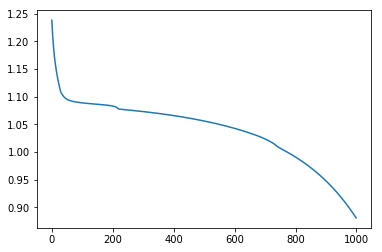

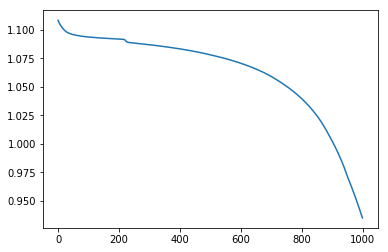

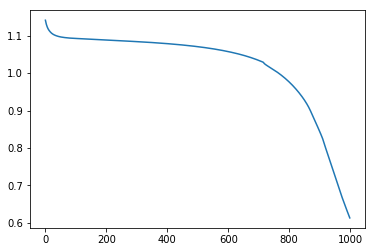

100.0 % accuracy at iteration 906


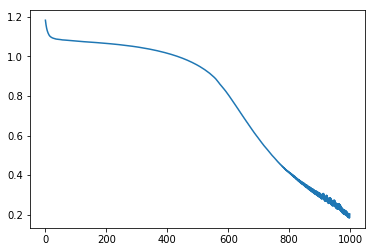

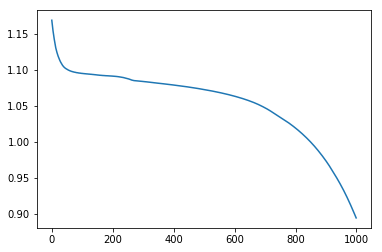

In [113]:
for i in range(5):
    lr = .00004
    epochs = 1000
    k = relumodel.train(x,y, showAccuracy = True, lr = lr, epochs = epochs, weightScaling = True, showPlot = True)

array([[0.28176421, 0.8054151 ],
       [0.3266286 , 0.48057354],
       [0.26294224, 0.17618523],
       ...,
       [0.50653041, 0.49004669],
       [0.57727172, 0.32204812],
       [0.52025855, 0.51900155]])

In [49]:
for i in range(100):
    print("Mu:", i/100)
    lr = .00004
    epochs = 4000
    k = relumodel.train(x,y, showAccuracy = True, lr = lr, epochs = epochs, weightScaling = True, showPlot = False, NAG = True, mu = (i/100))

Mu: 0.0
100.0 % accuracy at iteration 957
Mu: 0.01
100.0 % accuracy at iteration 1014
Mu: 0.02
100.0 % accuracy at iteration 999
Mu: 0.03
100.0 % accuracy at iteration 1002
Mu: 0.04
100.0 % accuracy at iteration 1434
Mu: 0.05
100.0 % accuracy at iteration 1006
Mu: 0.06
100.0 % accuracy at iteration 1439
Mu: 0.07
100.0 % accuracy at iteration 1181
Mu: 0.08
100.0 % accuracy at iteration 1358
Mu: 0.09
100.0 % accuracy at iteration 1305
Mu: 0.1
100.0 % accuracy at iteration 1297
Mu: 0.11
100.0 % accuracy at iteration 1053
Mu: 0.12
100.0 % accuracy at iteration 790
Mu: 0.13
100.0 % accuracy at iteration 2454
Mu: 0.14
100.0 % accuracy at iteration 690
Mu: 0.15
100.0 % accuracy at iteration 715
Mu: 0.16
100.0 % accuracy at iteration 928
Mu: 0.17
100.0 % accuracy at iteration 969
Mu: 0.18
100.0 % accuracy at iteration 847
Mu: 0.19
100.0 % accuracy at iteration 758
Mu: 0.2
100.0 % accuracy at iteration 673
Mu: 0.21
100.0 % accuracy at iteration 689
Mu: 0.22
100.0 % accuracy at iteration 654
Mu:

In [50]:
bestmu = .9
for i in range(5):
    lr = .00004
    epochs = 4000
    k = relumodel.train(x,y, showAccuracy = True, lr = lr, epochs = epochs, weightScaling = True, showPlot = False, NAG = True, mu = bestmu)

100.0 % accuracy at iteration 292
100.0 % accuracy at iteration 150
100.0 % accuracy at iteration 202
100.0 % accuracy at iteration 176
100.0 % accuracy at iteration 192


In [53]:
np.mean([292,150,202,176,192])

202.4

In [54]:
bestmu = .9
for i in range(5):
    lr = .00004
    epochs = 4000
    k = tanmodel.train(x,y, showAccuracy = True, lr = lr, epochs = epochs, weightScaling = True, showPlot = False, NAG = True, mu = bestmu)

As I stated before, my tanh never gets to 100% accuracy because it never converges. I tried running it with Nesterov momentum as a last-ditch effort, but still no dice.